## Pull anything

As a starting point, I want to try pulling one month of regridded data for any variable, working off of the [Accessing CEFI data with Python](https://noaa-cefi-portal.github.io/cefi-cookbook/content/data_access/access_cefi/python_get_cefi.html) documentation.

I'm also looking back at some other files:
* [Environmental Predictors](https://docs.google.com/spreadsheets/d/1tPmxlgaP8pwgAjt4m7omwbhQGHKxIfKaV-YM82VCUFM/edit?gid=1829421175#gid=1829421175)
* [Copy of Megan's Environmental Predictors](https://docs.google.com/spreadsheets/d/1MzrQR4iNgN_8TZ5Mc2ei2darMIsqhV9NZvTCkRt1QFE/edit?gid=643914782#gid=643914782)
* [ROMS request for Yellowtail](https://docs.google.com/spreadsheets/d/1uxJAqG5MHReSdr1pe_ASxqpCeAhqvuxYKr-qh2EFXPg/edit?gid=1062630878#gid=1062630878)
* [Groundfish Indices Variables from MOM6](https://docs.google.com/spreadsheets/d/1Z_bS9K7KEmnRCwz5ZAaQ49i6xC9JOaIeVcOjuQF59JI/edit?gid=0#gid=0)
* [Owen's code to pull GLORYS data](https://github.com/owenrliu/cefi-hake/blob/b5eeef46349673428788c42dcb2f0360f1686e3b/code/01_download_GLORYS.R)

In [1]:
import xarray as xr

I used the Data Query Generator at the [CEFI Data Portal](https://psl.noaa.gov/cefi_portal/#data_access) to generate a URL.
* Region: NEP
* Subregion: full domain
* Experiment Type: hindcast
* Output Frequency: monthly regrid
* Release: r20241015
* Data Category: ocean_monthly_z
* Variable: thetao (Sea Water Potential Temperature)

In [2]:
opendap_url = "http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/regrid/r20241015/thetao.nep.full.hcast.monthly.regrid.r20241015.199301-201912.nc"
ds_thetao = xr.open_dataset(opendap_url)

See the metadata and coordinates information for the dataset.

In [3]:
ds_thetao

<xarray.Dataset> Size: 19GB
Dimensions:  (time: 324, z_l: 52, lon: 341, lat: 815)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16T12:...
  * z_l      (z_l) float64 416B 2.5 7.5 12.5 17.5 ... 5.25e+03 5.75e+03 6.25e+03
  * lon      (lon) float64 3kB 156.9 157.2 157.5 157.8 ... 254.4 254.7 255.0
  * lat      (lat) float64 7kB 10.81 10.89 10.98 11.07 ... 80.55 80.63 80.72
Data variables:
    thetao   (time, z_l, lat, lon) float32 19GB ...
Attributes: (12/28)
    NumFilesInSet:          1
    title:                  NEP10k_082024_clean_spinup
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     volcello areacello
    ...                     ...
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_paper_doi:         10.5194/gmd-2024-195
    cefi_aux:               Postprocessed Data : regrid to regular grid
    _NCProperties:          version=2,netcdf=4.9.2,hdf5=1.14.3
    cefi_rel_path:          cefi_portal/northeast_pacific/full_domain/hindcas...
    cefi_ori_category:      ocean_monthly_z

The longitude is +360 degrees (i.e. -122 degrees E becomes +238 degrees), presumably to keep the number positive rather than negative.
The depth is in meters.

Load one day of data from the dataset.

* Try 1: one month of data, `time = '2012-12'`, stopped after 4 min
* Try 2: add latitude filter, `time = '2012-12', lat = 40, method = 'nearest'`, stopped after 6 min
* Try 3: add longitude filter, `time = '2012-12', lat = 156.9, lon = 10.81`, error because I mix up lat and long
* Try 4: fix filters and add depth to save time, `time = '2012-12', z_l = 2.5, lon = 156.9, lat = 40, method = 'nearest'`, took 10 seconds but got no numerical data
* Try 5: try different longitude, `time = '2012-12', z_l = 2.5, lon = 200, lat = 40, method = 'nearest'`, took 10 seconds and again got no numerical data
* Try 6: try a range for all variables, `time = '2012-12', z_l = slice(10, 15), lon = slice(200, 210), lat = slice(39.5, 40.5)`, took 10 seconds and finally got some data

I'm working off the [xarray sel documentation](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html#xarray.Dataset.sel).

In [4]:
ds_thetao_subset = ds_thetao.sel(time = '2012-12', z_l = slice(10, 15), lon = slice(200, 210), lat = slice(39.5, 40.5)).load()
ds_thetao_subset

<xarray.Dataset> Size: 2kB
Dimensions:  (time: 1, z_l: 1, lon: 35, lat: 11)
Coordinates:
  * time     (time) datetime64[ns] 8B 2012-12-16T12:00:00
  * z_l      (z_l) float64 8B 12.5
  * lon      (lon) float64 280B 200.2 200.5 200.8 201.0 ... 209.4 209.7 210.0
  * lat      (lat) float64 88B 39.58 39.67 39.75 39.84 ... 40.27 40.35 40.44
Data variables:
    thetao   (time, z_l, lat, lon) float32 2kB nan nan nan ... 11.33 11.28 11.43
Attributes: (12/28)
    NumFilesInSet:          1
    title:                  NEP10k_082024_clean_spinup
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     volcello areacello
    ...                     ...
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_paper_doi:         10.5194/gmd-2024-195
    cefi_aux:               Postprocessed Data : regrid to regular grid
    _NCProperties:          version=2,netcdf=4.9.2,hdf5=1.14.3
    cefi_rel_path:          cefi_portal/northeast_pacific/full_domain/hindcas...
    cefi_ori_category:      ocean_monthly_z

So I don't really understand what data I'm working with. What are the object types?

In [5]:
print(type(ds_thetao))
print(type(ds_thetao_subset))
print(type(ds_thetao_subset.thetao))

<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataarray.DataArray'>


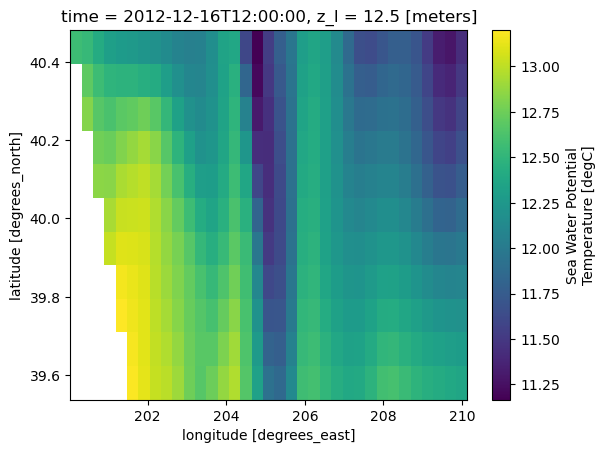

In [6]:
ds_thetao_subset.thetao.plot()

## Pull one month
Try to pull one month of data for Northern Yellowtail in copulation lifestage. Based on Environmental Predictors, that will be 90-180m depth, 116-130W longitude, 40-48N latitude, and start with August. (I'm choosing this variable arbitrarily, but want to see how long it takes to pull a slice this size.)

In [7]:
# filter paramaters
min_date = '2012-08-01'
max_date = '2012-08-31'
min_lat = 40
max_lat = 48
min_lon = 116
max_lon = 130
min_depth = 90
max_depth = 180

In [8]:
# get data, adjusting longitude to be +360 degrees
ds_thetao_subset = ds_thetao.sel(
    time = slice(min_date, max_date), 
    z_l = slice(min_depth, max_depth), 
    lon = slice(360-max_lon, 360-min_lon), 
    lat = slice(min_lat, max_lat)
).load()

Took 43 seconds!

In [9]:
ds_thetao_subset

<xarray.Dataset> Size: 128kB
Dimensions:  (time: 1, z_l: 7, lon: 48, lat: 94)
Coordinates:
  * time     (time) datetime64[ns] 8B 2012-08-16T12:00:00
  * z_l      (z_l) float64 56B 95.0 105.0 115.0 125.0 135.0 145.0 162.5
  * lon      (lon) float64 384B 230.2 230.5 230.7 231.0 ... 243.1 243.4 243.7
  * lat      (lat) float64 752B 40.01 40.1 40.18 40.27 ... 47.82 47.91 48.0
Data variables:
    thetao   (time, z_l, lat, lon) float32 126kB 9.189 9.489 9.515 ... nan nan
Attributes: (12/28)
    NumFilesInSet:          1
    title:                  NEP10k_082024_clean_spinup
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     volcello areacello
    ...                     ...
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_paper_doi:         10.5194/gmd-2024-195
    cefi_aux:               Postprocessed Data : regrid to regular grid
    _NCProperties:          version=2,netcdf=4.9.2,hdf5=1.14.3
    cefi_rel_path:          cefi_portal/northeast_pacific/full_domain/hindcas...
    cefi_ori_category:      ocean_monthly_z

How do you access information about the xarray data array? Looking at [xarray data structures docs](https://docs.xarray.dev/en/latest/user-guide/data-structures.html).
Remember python is 0-indexed, compared to R which is 1-indexed.

In [10]:
print(ds_thetao_subset.thetao.dims)
print(ds_thetao_subset.thetao.coords)
print(ds_thetao_subset.thetao.values[0,0,0,0])

('time', 'z_l', 'lat', 'lon')
Coordinates:
  * time     (time) datetime64[ns] 8B 2012-08-16T12:00:00
  * z_l      (z_l) float64 56B 95.0 105.0 115.0 125.0 135.0 145.0 162.5
  * lon      (lon) float64 384B 230.2 230.5 230.7 231.0 ... 243.1 243.4 243.7
  * lat      (lat) float64 752B 40.01 40.1 40.18 40.27 ... 47.82 47.91 48.0
9.189053


How to filter?

In [11]:
t = ds_thetao_subset.thetao
# try one filter condition
filtered_t = t.where(t.lon <= 231, drop = True)
# verify filtered coordinates are filtered right
filtered_t.coords

Coordinates:
  * time     (time) datetime64[ns] 8B 2012-08-16T12:00:00
  * z_l      (z_l) float64 56B 95.0 105.0 115.0 125.0 135.0 145.0 162.5
  * lon      (lon) float64 24B 230.2 230.5 230.7
  * lat      (lat) float64 752B 40.01 40.1 40.18 40.27 ... 47.82 47.91 48.0

In [12]:
# try two filter condition, added parentheses
filtered_t = t.where((t.lon <= 231) & (t.lat <= 45), drop = True)
# verify filtered coordinates are filtered right
filtered_t.coords

Coordinates:
  * time     (time) datetime64[ns] 8B 2012-08-16T12:00:00
  * z_l      (z_l) float64 56B 95.0 105.0 115.0 125.0 135.0 145.0 162.5
  * lon      (lon) float64 24B 230.2 230.5 230.7
  * lat      (lat) float64 472B 40.01 40.1 40.18 40.27 ... 44.82 44.9 44.99

## Pull one year

Try to pull one year of data for Northern Yellowtail in copulation lifestage. Based on Environmental Predictors, that will be 90-180m depth, 116-130W longitude, 40-48N latitude, and August-October. (Again I'm choosing this variable arbitrarily, but want to see how long it takes to pull a slice this size.)

In [13]:
# filter paramaters
min_date = '2012-08-01'
max_date = '2012-10-31'
min_lat = 40
max_lat = 48
min_lon = 116
max_lon = 130
min_depth = 90
max_depth = 180

# get data, adjusting longitude to be +360 degrees
ds_thetao_subset = ds_thetao.sel(
    time = slice(min_date, max_date), 
    z_l = slice(min_depth, max_depth), 
    lon = slice(360-max_lon, 360-min_lon), 
    lat = slice(min_lat, max_lat)
).load()

In [14]:
ds_thetao_subset

<xarray.Dataset> Size: 380kB
Dimensions:  (time: 3, z_l: 7, lon: 48, lat: 94)
Coordinates:
  * time     (time) datetime64[ns] 24B 2012-08-16T12:00:00 ... 2012-10-16T12:...
  * z_l      (z_l) float64 56B 95.0 105.0 115.0 125.0 135.0 145.0 162.5
  * lon      (lon) float64 384B 230.2 230.5 230.7 231.0 ... 243.1 243.4 243.7
  * lat      (lat) float64 752B 40.01 40.1 40.18 40.27 ... 47.82 47.91 48.0
Data variables:
    thetao   (time, z_l, lat, lon) float32 379kB 9.189 9.489 9.515 ... nan nan
Attributes: (12/28)
    NumFilesInSet:          1
    title:                  NEP10k_082024_clean_spinup
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     volcello areacello
    ...                     ...
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_paper_doi:         10.5194/gmd-2024-195
    cefi_aux:               Postprocessed Data : regrid to regular grid
    _NCProperties:          version=2,netcdf=4.9.2,hdf5=1.14.3
    cefi_rel_path:          cefi_portal/northeast_pacific/full_domain/hindcas...
    cefi_ori_category:      ocean_monthly_z

The variable size for `ds_thetao` in 19GB for three months. Looking at yellowtail, there are two temperature variables needed, and the life stages are at different depth ranges and the months don't overlap. So I'm thinking it'll be fastest to loop over each year for one life stage and calculate the average temperature, then loop over each year for the other life stage and calculate the average temperature. (I wonder if there's a way to parallelize this better, and there probably is but not running on my laptop.)

| Variable | Life stage | Depth | Lon | Lat |
|-|-|-|-|-|
Tcop | 90 - 180 m  | 116-130W | 40-48N | Aug - Oct
Tpart | Temperature | parturition | 0 - 180 m  | 116-130W | 40-48N | Jan - Apr (peak in Feb)